In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm_notebook
from source.datautil import *
from source.model import *
from source.trainutil import *
DEVICE = "cpu" # or "cuda:0"
# torch.cuda.set_device(DEVICE) # uncomment this for CUDA

## CLEVR Dataset Prepare

In [3]:
# The first step is to download the CLEVR dataset from
# https://cs.stanford.edu/people/jcjohns/clevr/
# Download CLEVR v1.0 (18 GB) 
# Make sure the data utility can get image and mask without problem

In [4]:
data_path_json_train = "dataset/json_clevr_train_with_mask.data"
PATH_TO_IMAGES_TRAIN = "/storage/hezq17/CLEVR_v1.0/images/train" # change this to where you download the images
data_path_images_train = PATH_TO_IMAGES_TRAIN
data_path_json_val = "dataset/json_clevr_val_with_mask.data"
PATH_TO_IMAGES_VAL = "/storage/hezq17/CLEVR_v1.0/images/val" # change this to where you download the images
data_path_images_val = PATH_TO_IMAGES_VAL

Data load from  dataset/json_clevr_train_with_mask.data
Parsing dataset ...


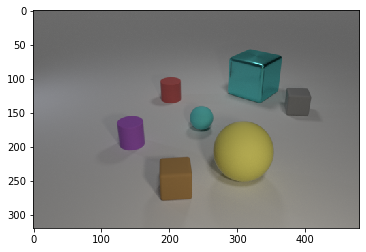

In [5]:
# Test ClevrDataset utility
clrdata = ClevrDataset(data_path_json_train, data_path_images_train)
clrdata.get_mode="full"
rndpick = np.random.rand()*len(clrdata)
img, mask_t, json_scene = clrdata[int(rndpick)]
plt.imshow(img)
plt.show()

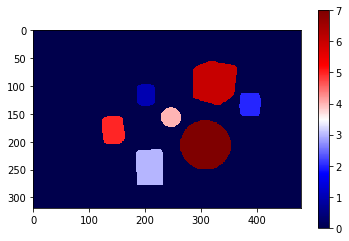

In [6]:
plot_mat(mask_t)

## Task 1: Supervise Learning of Properties.

In [7]:
clrdata = ClevrDataset(data_path_json_train, data_path_images_train, get_mode="maskedimage_posicolormaterial")
clrdata_val = ClevrDataset(data_path_json_val, data_path_images_val, get_mode="maskedimage_posicolormaterial")

data_loader = torch.utils.data.DataLoader(
    clrdata, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)

data_loader_val = torch.utils.data.DataLoader(
    clrdata_val, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)

Data load from  dataset/json_clevr_train_with_mask.data
Parsing dataset ...
Data load from  dataset/json_clevr_val_with_mask.data
Parsing dataset ...


In [8]:
model_para={
    "input_H":320,
    "input_W":480,
    "output_size": 2+8+2, # posix, posiy, color, material
    "conv_para":[[3,16,7,2],[16,32,5,1],[32,32,5,1],[32,32,5,1]],
    "maxpool_para": 2,
    "mlp_para": [128,64],
    "res_per_conv":1
}
misc_para = {
    "postprocess_mode":"gaussian_noise",
    "postprocess_partition": [2,10,12],
    "noise_std":0.2e-2
}
cnn = ConvNet(model_para, para=misc_para)

misc_para = {
    "loss_flag": "posicolormaterial_loss",
}

loss = CAL_LOSS(cnn,para=misc_para)

Calculated Hsize: 6.0, Wsize: 11.0, ConvOut:2112.


In [9]:
data_dict={"train":data_loader,"val":data_loader_val}
run_para={"loss_clip":0.2}
ptM = PyTrain_Main(loss, data_dict, device=DEVICE, para=run_para)

In [10]:
# Adjust epoch number and learning rate until converge
ptM.run_training(epoch=10, lr=1e-4, optimizer_label="adam", print_step=200)

In [11]:
# Or load a pretrained model
load_model(cnn,"pretrained_models/CNN_posiColorMaterial_sqrt0p2%_gaussNoise.model",map_location=DEVICE)

Model load from  pretrained_models/CNN_posiColorMaterial_sqrt0p2%_gaussNoise.model


ConvNet(
  (conv_layer_stack): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): LayerNorm((157, 237), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): LayerNorm((74, 114), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): LayerNorm((33, 53), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): LayerNorm((12, 22), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): 

In [12]:
ptM.do_eval()

Start evaluation ... 235


235it [05:37,  1.44s/it]

Evaluation Perplexity:  0.022089182181244203
Time used in evaluation:  337.64008116722107


## Auto-encoding

In [13]:
model_para={
    "input_H":320,
    "input_W":480,
    "output_size": 128, # posix, posiy, color, shape
    "conv_para":[[3,16,7,2],[16,32,5,1],[32,32,5,1],[32,32,5,1]],
    "maxpool_para": 2,
    "mlp_para": [512,256],
    "res_per_conv":1,
    "infobn_model":{"gs_head_dim":2, "gs_head_num":64}
}

reg_lamda_scale = 64
misc_para = {
    "postprocess_mode": "GSVIB",
    "infobn_para": {"temp_scan_num":4,"reg_lamda":0.008*reg_lamda_scale,"scale_factor":1.0}
}

cnn2 = ConvNet(model_para,para = misc_para)

cnn.sfmsample_flag = True

misc_para = {
    "cooprer_train_flag": False,
    "coop_mode": "concatenate"
}
encoder = ABS_CNN_COOP(cnn, cnn2, para=misc_para)

Calculated Hsize: 6.0, Wsize: 11.0, ConvOut:2112.


In [14]:
model_para={
    "input_size": 2+8+2+128, # posix, posiy, shape, material
    "output_H":150,
    "output_W":150,
    "deconv_para":[[32,32,5,1], [32,16,5,1],[16,3,7,2]],
    "maxunpool_para": 2,
    "mlp_para": [256,512],
    "res_per_conv": 1
}
misc_para = {}
decnn = DeConvNet(model_para, para=misc_para)

misc_para = {
    "seq1_coop_train_flag": True
}
autoenc = ABS_CNN_SEQ(encoder, decnn, para=misc_para)

Calculated Hsize: 6.0, Wsize: 6.0, ConvOut:1152.
Actual output shape (149.0,149.0).


In [15]:
misc_para={"loss_flag":"mse_loss"}
loss = CAL_LOSS(autoenc,para=misc_para)

In [16]:
clrdata.get_mode="auto_encode_focused"
clrdata_val.get_mode="auto_encode_focused"

data_loader = torch.utils.data.DataLoader(
    clrdata, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)

data_loader_val = torch.utils.data.DataLoader(
    clrdata_val, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)

In [17]:
data_dict={"train":data_loader,"val":data_loader_val}
run_para={"loss_clip":20}
ptM = PyTrain_Main(loss, data_dict, device=DEVICE, para=run_para)

In [18]:
# Adjust epoch number and learning rate until converge
# It takes pretty long time for this step
ptM.run_training(epoch=100, lr=1e-4, optimizer_label="adam", print_step=200)

In [19]:
load_model(autoenc,"pretrained_models/Autoenc_InfoB_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.model",map_location=DEVICE)

Model load from  pretrained_models/Autoenc_InfoB_PCM_10p53_h64reg0p5_pgnoise2e-3_focusMode_posiIncld.model


ABS_CNN_SEQ(
  (seq1_coop): ABS_CNN_COOP(
    (cooprer): ConvNet(
      (conv_layer_stack): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
          (1): LayerNorm((157, 237), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
          (1): LayerNorm((74, 114), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
          (1): LayerNorm((33, 53), eps=1e-05, elementwise_affine=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (3): Sequential(
          (0): Conv2

In [20]:
ptM.do_eval()

Start evaluation ... 235


235it [12:32,  3.20s/it]


Evaluation Perplexity:  10.472011829944368
Time used in evaluation:  753.0462112426758


## AutoEncode Output Image Check

In [66]:
idp = int(np.random.rand()*15000)
datax, labels = clrdata_val[idp]
res = autoenc(datax.view(1,3,320,480).to(DEVICE), schedule=1.0)

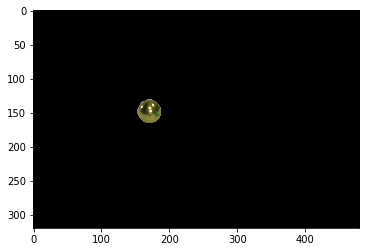

In [67]:
inimage = datax.permute(1,2,0)
plt.imshow(inimage)
plt.show()

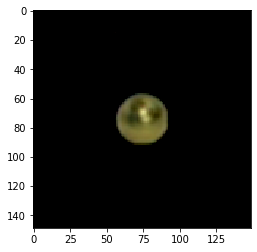

In [68]:
outimage = autoenc.seq2_train.outimage.detach().cpu().squeeze().permute(1,2,0).numpy()
plt.imshow(outimage)
plt.show()

## Autoencoder pre-process to prepare for task2

In [69]:
clrdata.get_mode="whole_pic_auto"
clrdata_val.get_mode="whole_pic_auto"
data_loader = torch.utils.data.DataLoader(
    clrdata, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)
data_loader_val = torch.utils.data.DataLoader(
    clrdata_val, batch_size=64, shuffle=True, num_workers=4, collate_fn=None)

In [70]:
for ii in tqdm_notebook(range(len(clrdata_val))):
    autoenc.auto_code_context_flag=True
    loss = autoenc(clrdata_val[ii][0].to(DEVICE))
    Nobj = len(clrdata_val.json_clevr["scenes"][ii]["objects"])
    for iio in range(Nobj):
        contx = np.array(autoenc.auto_code_context[iio,:].detach().cpu())
        clrdata_val.json_clevr["scenes"][ii]["objects"][iio]["auto_code"]=contx

In [71]:
save_data(clrdata_val.json_clevr,"somedata_val.data")

In [72]:
autoenc.to(DEVICE)
for ii in tqdm_notebook(range(len(clrdata))):
    autoenc.auto_code_context_flag=True
    loss = autoenc(clrdata[ii][0].to(DEVICE))
    Nobj = len(clrdata.json_clevr["scenes"][ii]["objects"])
    for iio in range(Nobj):
        contx = np.array(autoenc.auto_code_context[iio,:].detach().cpu())
        clrdata.json_clevr["scenes"][ii]["objects"][iio]["auto_code"]=contx

In [73]:
save_data(clrdata.json_clevr,"somedata_train.data")